## Objective

#### NLP sentiment classification on news headlines
Using APIs or a little webscraping to harvest some new test data that you will manually label the new headlines as negative/positive and then see how your model does on those headlines.

#### Dataset:
[Sentiment Analysis for Financial News](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news)

## Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLTK - Stopwords:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from gensim.models.doc2vec import TaggedDocument
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

#to see the entire column width:
pd.set_option('display.max_colwidth', -1)

In [2]:
import tensorflow as tf
tf.__version__

'2.3.1'

### Imoport Data

In [3]:
df = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                 encoding='latin-1')
df = df.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
display(df.head())
print("Shape:", df.shape, "\n\n")
print(df.info())

Sentiment  \
0  positive   
1  neutral    
2  neutral    
3  neutral    
4  positive   

                                                                                                                                                                                                                                          Headline  
0  Finnish elevators and escalators maker KONE Corporation said on Tuesday ( 18 March ) that it has received a major order from Sir Robert McAlpine to supply all elevators and escalators for the Watermark Place project in the City of London .  
1  The contract includes an option to deliver an additional 75 ASCs in the next phases of the project .                                                                                                                                             
2  Mr. Kari Stadigh will carry on as Chairman of the Board and Mr. Matti Arteva as Vice-Chairman .                                                                                                                                                  
3  The agreement is valid for four years .                                                                                                                                                                                                          
4  The recovery of demand that started toward the end of 2009 , continued in January-March 2010 .

Shape: (4846, 2) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4846 non-null   object
 1   Headline   4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB
None


In [4]:
# Look at the instances of each sentiment
df.Sentiment.value_counts()

neutral     2879
positive    1363
negative    604 
Name: Sentiment, dtype: int64

#### Visualize the data

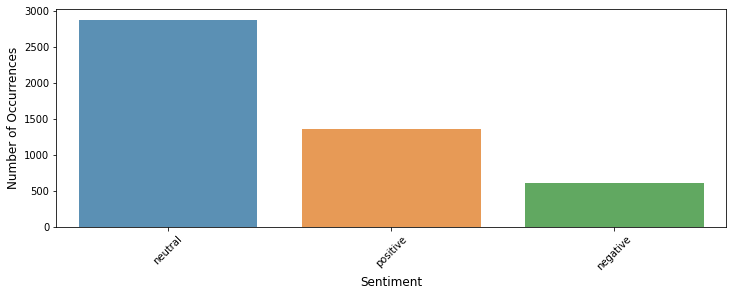

In [5]:
cnt_pro = df['Sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(rotation=45)
plt.show();

### Clean the Data

In [6]:
# Convert the string in the 'Sentiment' column to numeric form
Sentiment = {'positive': 0, 'neutral': 1, 'negative': 2} 

#df[Sentiment]=df[Sentiment].map(Sentiment)

In [7]:
# traversing through Sentiment column and writing values where key matches
df.Sentiment = [Sentiment[item] for item in df.Sentiment] 
df.head(10)

Sentiment  \
0  0           
1  1           
2  1           
3  1           
4  0           
5  1           
6  1           
7  2           
8  0           
9  1           

                                                                                                                                                                                                                                                     Headline  
0  Finnish elevators and escalators maker KONE Corporation said on Tuesday ( 18 March ) that it has received a major order from Sir Robert McAlpine to supply all elevators and escalators for the Watermark Place project in the City of London .             
1  The contract includes an option to deliver an additional 75 ASCs in the next phases of the project .                                                                                                                                                        
2  Mr. Kari Stadigh will carry on as Chairman of the Board and Mr. Matti Arteva as Vice-Chairman .                                                                                                                                                             
3  The agreement is valid for four years .                                                                                                                                                                                                                     
4  The recovery of demand that started toward the end of 2009 , continued in January-March 2010 .                                                                                                                                                              
5  The evidentiary hearing in the Investigation is scheduled for April 21 - May 1 , 2008 .                                                                                                                                                                     
6  The lay-offs will start gradually and will last from one to six weeks .                                                                                                                                                                                     
7  Revenue was slightly down , at  x20ac 495 million $ 634 million , compared to  x20ac 497 million a year earlier .                                                                                                                                           
8  `` This contract demonstrates our ability to apply our minerals and metals technologies in adjacent industries , such as oil shale processing .                                                                                                             
9  The Estonian beverages maker A. Le Coq today brought to the market a new premium class beer , A. Le Coq Special , investing 6 million kroons EUR 383,000 into its development and planning to sell three million liters of the beer during the next year .

#### Stopwords:
Remove words from strings that have no unique information ('is','an','the).

In [8]:
#nltk.download('stopwords')

stop = set(stopwords.words('english'))
stop.add("'s")
for item in string.punctuation:
    stop.add (item)
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

df['Headline'] = df['Headline'].map(remove_stopwords)

In [9]:
#make a new column for clean headlines and then other columns for different version of data

In [10]:
#check
df.head()

Sentiment  \
0  0           
1  1           
2  1           
3  1           
4  0           

                                                                                                                                                                             Headline  
0  finnish elevators escalators maker kone corporation said tuesday 18 march received major order sir robert mcalpine supply elevators escalators watermark place project city london  
1  contract includes option deliver additional 75 ascs next phases project                                                                                                             
2  mr. kari stadigh carry chairman board mr. matti arteva vice-chairman                                                                                                                
3  agreement valid four years                                                                                                                                                          
4  recovery demand started toward end 2009 continued january-march 2010

#### Lemmatization:
Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. [Lemmatization](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/)

In [11]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [12]:
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text = [wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split()]
    return " ".join(text)

df['Headline_Lemma'] = df['Headline'].map(lemmatize)

In [13]:
#check
df.head()

Sentiment  \
0  0           
1  1           
2  1           
3  1           
4  0           

                                                                                                                                                                             Headline  \
0  finnish elevators escalators maker kone corporation said tuesday 18 march received major order sir robert mcalpine supply elevators escalators watermark place project city london   
1  contract includes option deliver additional 75 ascs next phases project                                                                                                              
2  mr. kari stadigh carry chairman board mr. matti arteva vice-chairman                                                                                                                 
3  agreement valid four years                                                                                                                                                           
4  recovery demand started toward end 2009 continued january-march 2010                                                                                                                 

                                                                                                                                                                 Headline_Lemma  
0  finnish elevator escalator maker kone corporation say tuesday 18 march receive major order sir robert mcalpine supply elevator escalator watermark place project city london  
1  contract include option deliver additional 75 ascs next phase project                                                                                                         
2  mr. kari stadigh carry chairman board mr. matti arteva vice-chairman                                                                                                          
3  agreement valid four year                                                                                                                                                     
4  recovery demand start toward end 2009 continued january-march 2010

WordCloud to see the commonly used words

In [14]:
#!pip install wordcloud

In [15]:
# Separating out the categories
# pos = df.Headline[df.Sentiment[df.Sentiment== 1].index]
# neg = df.Headline[df.Sentiment[df.Sentiment== 0].index]

In [16]:
def wordcloud(dataset):
    plt.figure(figsize = (18,24)) # Text Reviews with positive Ratings
    wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1000, 
                          height = 600,
                          collocations=False).generate(" ".join(dataset))
    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show();

def show_wordclouds(column='Headline'):
    # Separating out the categories
    pos = df[column][df.Sentiment[df.Sentiment== 1].index]
    neg = df[column][df.Sentiment[df.Sentiment== 0].index]
    print ('Positive Sentiment Wordcloud:')
    wordcloud(pos)
    
    print ('Negative Sentiment Wordcloud:')
    wordcloud(neg)
    

Positive Sentiment Wordcloud:


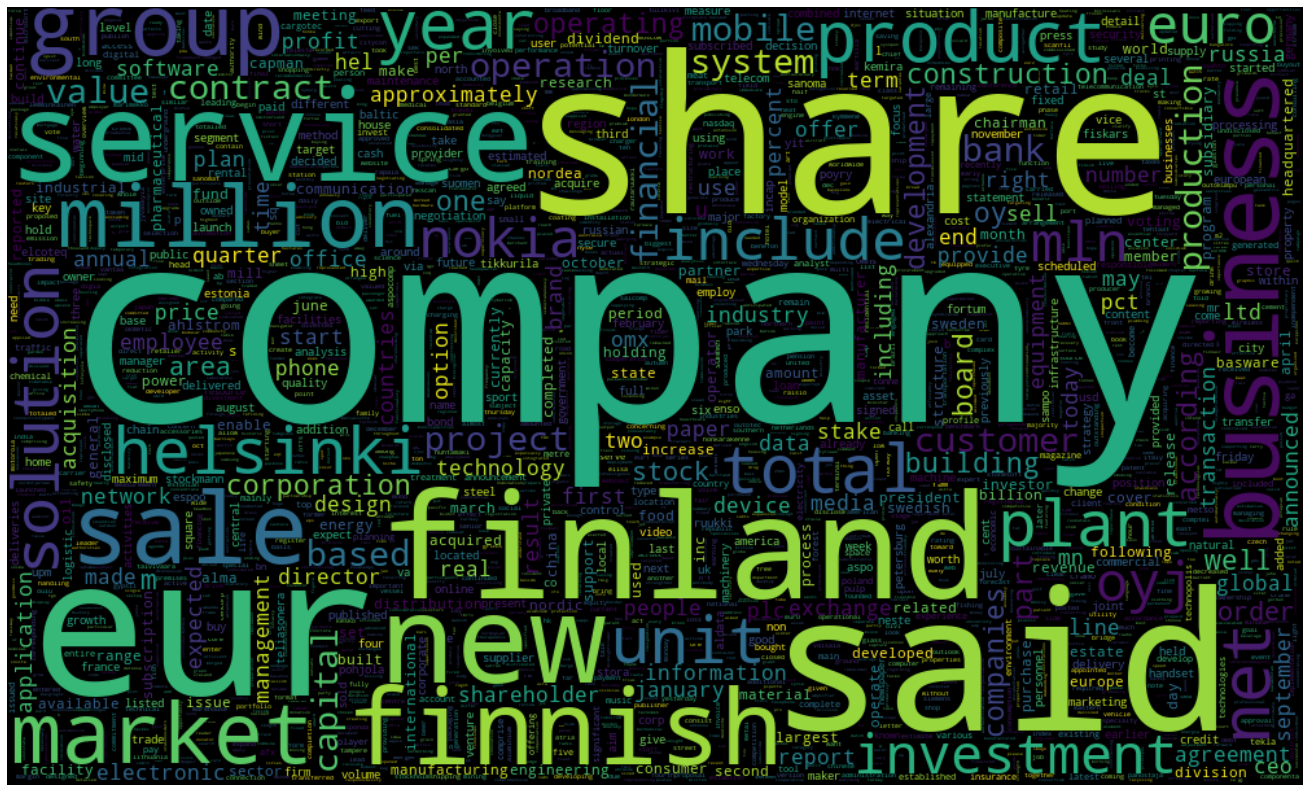

Negative Sentiment Wordcloud:


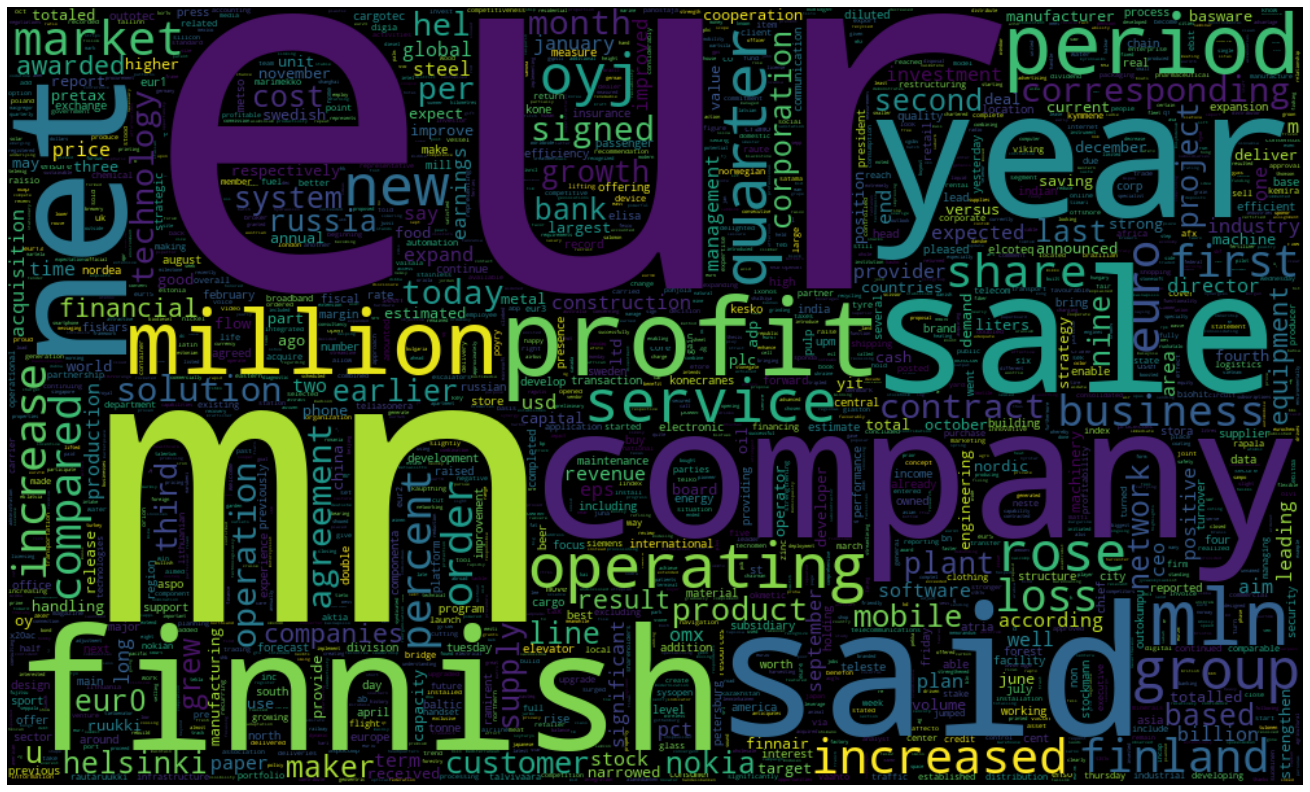

In [17]:
show_wordclouds()

Positive Sentiment Wordcloud:


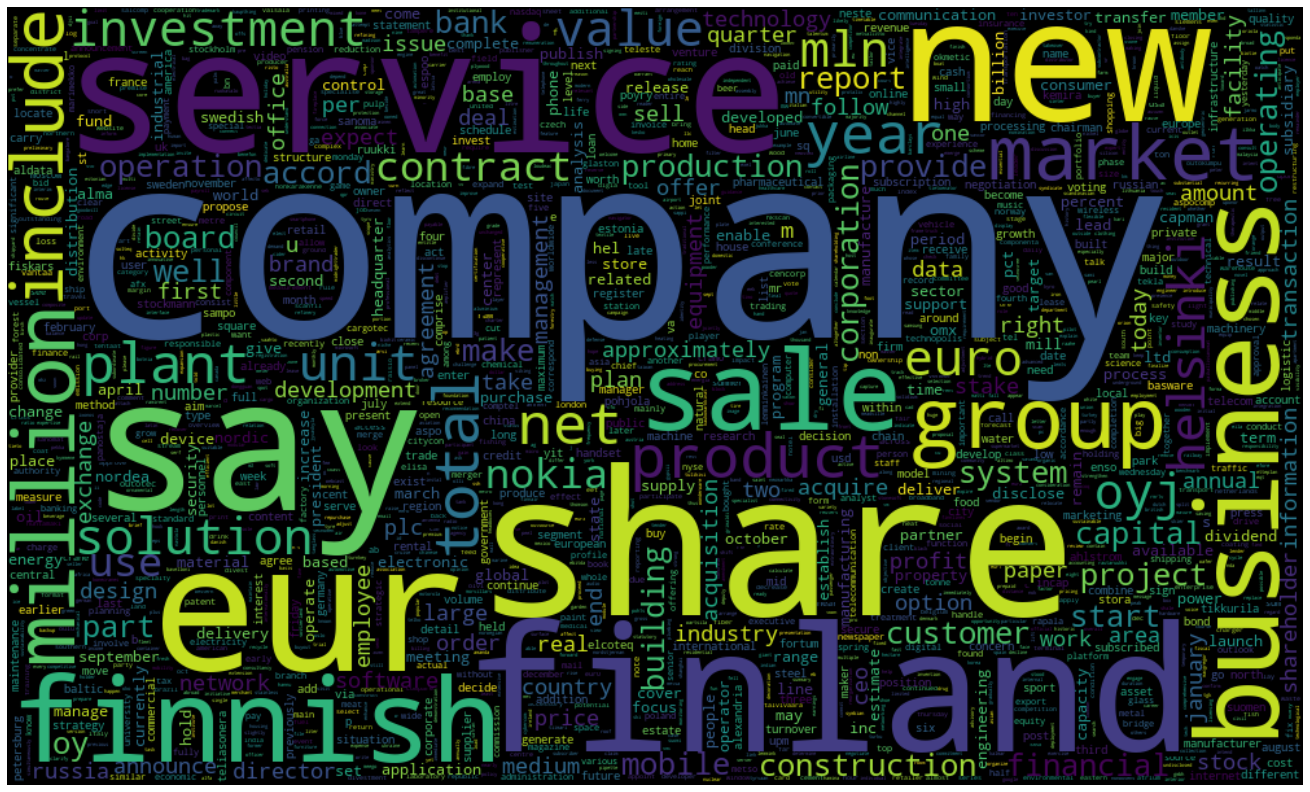

Negative Sentiment Wordcloud:


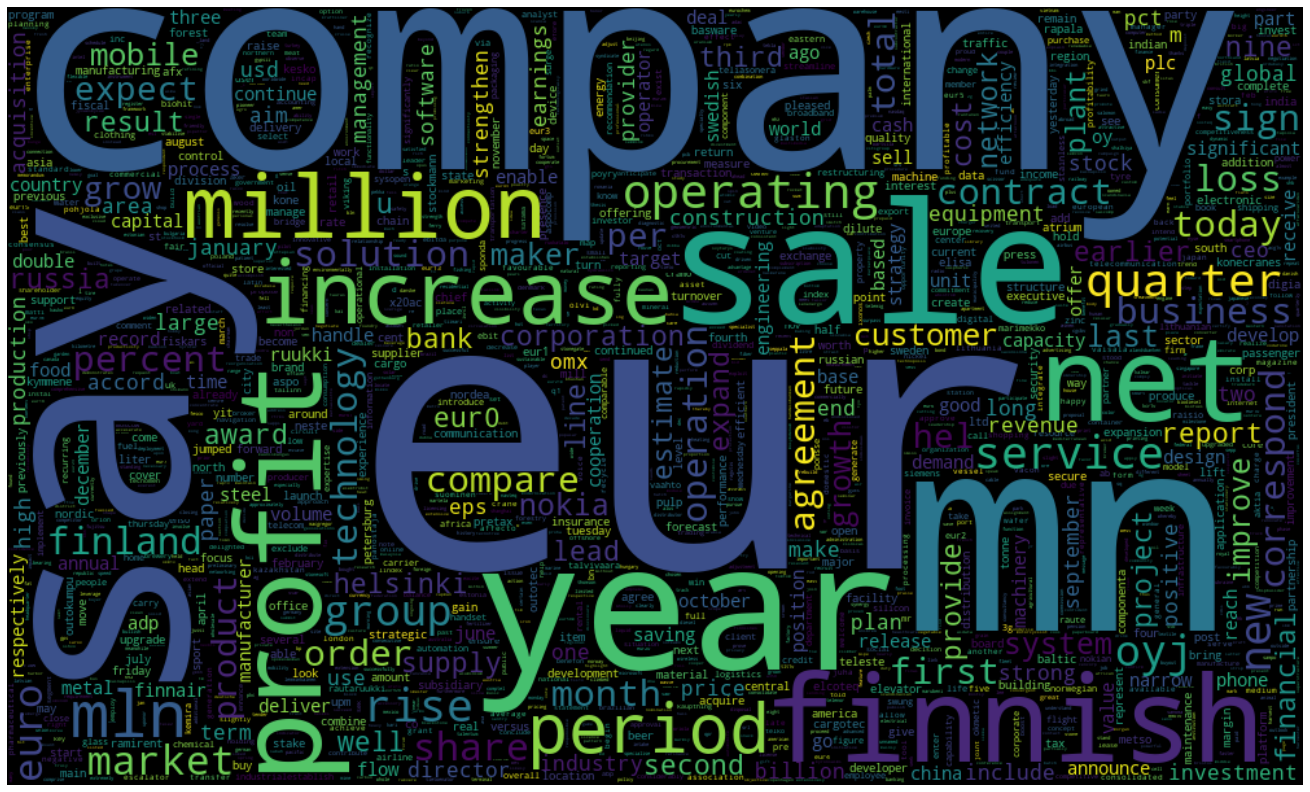

In [18]:
show_wordclouds('Headline_Lemma')

Process the text to convert text to lower-case strip punctuations and symbols etc.

In [19]:
from bs4 import BeautifulSoup
import re

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text


df['Headline_soup'] = df['Headline_Lemma'].apply(cleanText)


In [20]:
df.head()

Sentiment  \
0  0           
1  1           
2  1           
3  1           
4  0           

                                                                                                                                                                             Headline  \
0  finnish elevators escalators maker kone corporation said tuesday 18 march received major order sir robert mcalpine supply elevators escalators watermark place project city london   
1  contract includes option deliver additional 75 ascs next phases project                                                                                                              
2  mr. kari stadigh carry chairman board mr. matti arteva vice-chairman                                                                                                                 
3  agreement valid four years                                                                                                                                                           
4  recovery demand started toward end 2009 continued january-march 2010                                                                                                                 

                                                                                                                                                                 Headline_Lemma  \
0  finnish elevator escalator maker kone corporation say tuesday 18 march receive major order sir robert mcalpine supply elevator escalator watermark place project city london   
1  contract include option deliver additional 75 ascs next phase project                                                                                                          
2  mr. kari stadigh carry chairman board mr. matti arteva vice-chairman                                                                                                           
3  agreement valid four year                                                                                                                                                      
4  recovery demand start toward end 2009 continued january-march 2010                                                                                                             

                                                                                                                                                                  Headline_soup  
0  finnish elevator escalator maker kone corporation say tuesday 18 march receive major order sir robert mcalpine supply elevator escalator watermark place project city london  
1  contract include option deliver additional 75 ascs net phase project                                                                                                          
2  mr. kari stadigh carry chairman board mr. matti arteva vice-chairman                                                                                                          
3  agreement valid four year                                                                                                                                                     
4  recovery demand start toward end 2009 continued january-march 2010

#### Counter

In [21]:
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [22]:
text = df.Headline_Lemma
counter = counter_word(text)

In [23]:
len(counter)

10088

In [24]:
num_words = len(counter)

### Train/Test Split

In [25]:
# headlines = []
# labels = []

# for row in range(len(df)):
#     headlines.append(df['Headline_soup'][row])
#     labels.append(df['Sentiment'][row])

In [26]:
training_headlines, testing_headlines, training_labels, testing_labels = train_test_split(
    df['Headline_soup'], df['Sentiment'], test_size=0.2 , random_state=42)

In [27]:
# # Setting the training ratio
# training_size = int(df.shape[0] * .8) 

# # Train Test Split:
# # Already shuffled, so we're good to go
# training_headlines = headlines[0:training_size]
# testing_headlines = headlines[training_size:]
# training_labels = labels[0:training_size]
# testing_labels = labels[training_size:]

In [28]:
# Checking on a few of the headlines:
display(training_headlines[:3])
display(training_labels[:3])

432     november finnish government decrease ownership company 31.1 percent 38 percent                              
3071    potential acquirer cencorp corporation related entity sav owe sav cencorp subsidiary finnish savcor group oy
289     viking pay eur 130 million new ship complete january 2008                                                   
Name: Headline_soup, dtype: object

432     1
3071    1
289     1
Name: Sentiment, dtype: int64

In [29]:
training_labels

432     1
3071    1
289     1
2588    0
4121    1
       ..
4426    0
466     2
3092    2
3772    1
860     0
Name: Sentiment, Length: 3876, dtype: int64

In [30]:
testing_labels

3207    0
1684    2
1044    1
4145    1
1538    1
       ..
3691    0
1507    1
1126    0
180     0
1215    2
Name: Sentiment, Length: 970, dtype: int64

### Tokenizer 
Tokenizing involoves splitting sentances and words from the body of the text
The use of a tokenizer creates a number coded to each word thereby allowing 
the neural network to build patterns and learn meaning.

In [31]:
# function to tokenize text

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens

In [32]:
# apply the splits to the tokenizer

# Gensim is a Python library for topic modeling, document indexing and Similarity retrieval with large corpora.
#[Gensim](https://pypi.org/project/gensim/)
# train_tagged = train.apply(
#     lambda r: TaggedDocument(words=tokenize_text(r['Headline']), tags=[r.Sentiment]), axis=1)
# test_tagged = test.apply(
#     lambda r: TaggedDocument(words=tokenize_text(r['Headline']), tags=[r.Sentiment]), axis=1)

In [33]:
# set the maximum words to be used
max_features = 500000

# set the maximum words in each headline
max_sequence_length = 50

tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(training_headlines)
X_train = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(X_train)
print('Found %s unique tokens.' % len(training_padded))


Found 3876 unique tokens.


In [34]:
# check the shape of data tensor:
X_test = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(X_test, maxlen=max_sequence_length)
print('Shape of data tensor:', testing_padded.shape)

Shape of data tensor: (970, 50)


In [35]:
embedding_dim = 32
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [36]:
# # Initializing the fitting the tokenizer:
# tokenizer = Tokenizer(num_words = num_words, oov_token = oov_tok)
# tokenizer.fit_on_texts(training_headlines)
# # Initializing the Word Index:
# word_index = tokenizer.word_index
# # Padding and Sequencing the Training Set:
# training_sequences = tokenizer.texts_to_sequences(training_headlines)
# training_padded = pad_sequences(training_sequences, maxlen = max_length,
#                                padding = padding_type, 
#                                truncating = trunc_type)
# # Padding and Sequencing the Testing Set:
# testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
# testing_padded = pad_sequences(testing_sequences, maxlen = max_length, 
#                                padding = padding_type, 
#                                truncating = trunc_type)


In [37]:
# # Switch to Numpy Array
# # Necessary for the ANN to read the data
# training_padded = np.array(training_padded)
# training_labels = np.array(training_labels)
# testing_padded = np.array(testing_padded)
# testing_labels = np.array(testing_labels)

In [38]:
print ('Padded and Tokenized Headline:\n', training_padded[3])
print ('\nThe actual headline:\n', training_headlines[3])
print ('\nLabel:\n', training_labels[3])

Padded and Tokenized Headline:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    4 3751 1741   14 2603 3752   34  271   32   10   12
 3753   42   39    7    7   24   43  282   91   45  651   10   51 3754
   42   39 3755   42   30   83]

The actual headline:
 agreement valid four year

Label:
 1


In [39]:
# train
#train_tagged.values

In [40]:
from tensorflow.keras.utils import to_categorical
training_labels_ohe = to_categorical(training_labels)
testing_labels_ohe = to_categorical(testing_labels)

testing_labels_ohe[0]

array([1., 0., 0.], dtype=float32)

### Model 1 (Hidden Layer)

In [41]:
# embedding_dim = 100

# model = Sequential()
# model.add(Embedding(num_words, embedding_dim, input_length=64))
# model.add(Dense(200, activation='relu'))
# model.add(Dropout(0.2)) # Optional Regularization
# model.add(Dense(3, activation='sigmoid'))

# # Slower learning rate worked better as it kept the learning more stable
# #opt = keras.optimizers.Adam(lr=0.0001)
# model.compile(loss='categorical_crossentropy',optimizer='adam', 
#               metrics=['accuracy']) # Orig code

In [42]:
# num_epochs = 50
# # After 5 epochs of validation loss not improving, the model will stop.
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# history = model.fit(training_padded, training_labels, 
#                     epochs=num_epochs,
#                     batch_size = 10,
#                     validation_data=(testing_padded, testing_labels), 
#                     verbose= 1, callbacks=[es])

### Functions for Model Evaluation:

In [43]:
#results.history.keys()

In [44]:



def model_eval(history):
    pd.DataFrame(history.history).plot(figsize = (12,8)) 
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show
def plot_graphs(history, string):
    
#     history = results.history
#     plt.figure()
#     plt.plot(history['val_loss'])
#     plt.plot(history['loss'])
#     plt.legend(['val_loss', 'loss'])
#     plt.title('Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.show()
    
#     plt.figure()
#     plt.plot(history['val_accuracy'])
#     plt.plot(history['accuracy'])
#     plt.legend(['val_acc', 'acc'])
#     plt.title('Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.show()
    
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

def model_metrics(model):
    train_acc = model.evaluate(training_padded, training_labels, verbose=0)
    test_acc = model.evaluate(testing_padded, testing_labels, verbose=0)
    print('Train Loss:', "{:.3%}".format(train_acc[0]))
    print('Train Accuracy:', "{:.3%}".format(train_acc[1]))
    print('Test Loss:', "{:.3%}".format(test_acc[0]))
    print('Test Accuracy:', "{:.3%}".format(test_acc[1]))
    
# Made up some easy headlines to see if the ANN works
def easy_headlines():
    sentence = ["stock rise rapid for tesla", 
                "apple factory shut down, lay off hundred employee",
                "average day of return for microsoft"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))
    
# Random headlines from NYT Business  (post stopword removal and lemmatization) 
# This may be a bit trickier for the network
def harder_headlines():
    sentence = ["snowflake more  double  debut  wall street embrace tech ipos", 
                "europe economic revival imperil raising the specter grind downturn",
                "fed debate next step after shifting approach to rate setting"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))

def test_headlines():
    print('Easier Headlines:')
    easy_headlines()
    print ('\n')
    print ('Realistic Headlines:')
    harder_headlines()

In [45]:
#model_metrics(model)

In [47]:
#test_headlines()

### Model 2 (LSTM):

In [48]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           1008800   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 1,053,219
Trainable params: 1,053,219
Non-trainable params: 0
_________________________________________________________________


In [50]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels_ohe, 
                    epochs=num_epochs,
                    batch_size = 24,
                    validation_data=(testing_padded, testing_labels_ohe), 
                    verbose= 1, callbacks = [es])

Epoch 1/50
162/162 [==============================] - 6s 39ms/step - loss: 0.8474 - accuracy: 0.6285 - val_loss: 0.7366 - val_accuracy: 0.6845
Epoch 2/50
162/162 [==============================] - 6s 35ms/step - loss: 0.5737 - accuracy: 0.7572 - val_loss: 0.7330 - val_accuracy: 0.7072
Epoch 3/50
162/162 [==============================] - 6s 38ms/step - loss: 0.3027 - accuracy: 0.8860 - val_loss: 0.8505 - val_accuracy: 0.7227
Epoch 4/50
162/162 [==============================] - 6s 39ms/step - loss: 0.1524 - accuracy: 0.9489 - val_loss: 1.0212 - val_accuracy: 0.7144
Epoch 5/50
162/162 [==============================] - 6s 37ms/step - loss: 0.0848 - accuracy: 0.9737 - val_loss: 1.2142 - val_accuracy: 0.7196
Epoch 6/50
162/162 [==============================] - 6s 37ms/step - loss: 0.0516 - accuracy: 0.9830 - val_loss: 1.3877 - val_accuracy: 0.7072
Epoch 7/50
162/162 [==============================] - 6s 37ms/step - loss: 0.0469 - accuracy: 0.9863 - val_loss: 1.4778 - val_accuracy: 0.7165

In [51]:
model_metrics(model)

ValueError: in user code:

    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1208 run_step  **
        outputs = model.test_step(data)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1177 test_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 3) are incompatible


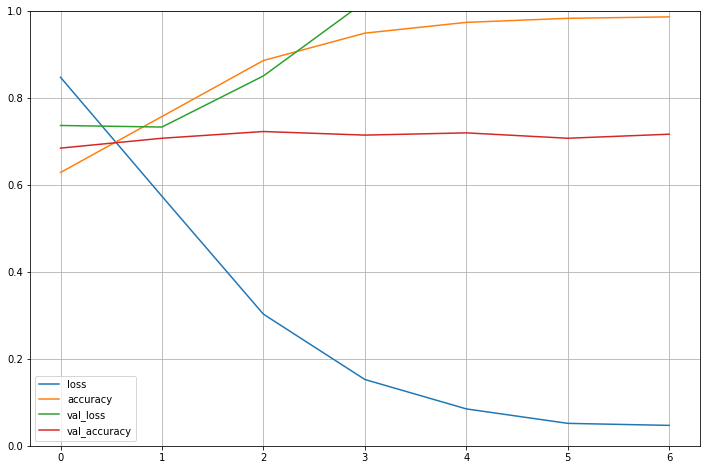

In [52]:
model_eval(history)

In [53]:
embedding_dim = 32

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [54]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels_ohe, 
                    epochs=num_epochs,
                    batch_size = 32,
                    validation_data=(testing_padded, testing_labels_ohe), 
                    #validation_split = .1,
                    verbose= 1, callbacks = [es])

Epoch 1/50
122/122 [==============================] - 4s 36ms/step - loss: 0.9291 - accuracy: 0.5924 - val_loss: 0.8342 - val_accuracy: 0.6351
Epoch 2/50
122/122 [==============================] - 4s 31ms/step - loss: 0.7175 - accuracy: 0.6865 - val_loss: 0.7871 - val_accuracy: 0.6804
Epoch 3/50
122/122 [==============================] - 4s 29ms/step - loss: 0.5000 - accuracy: 0.7822 - val_loss: 0.8386 - val_accuracy: 0.6753
Epoch 4/50
122/122 [==============================] - 4s 31ms/step - loss: 0.3312 - accuracy: 0.8664 - val_loss: 0.7802 - val_accuracy: 0.7103
Epoch 5/50
122/122 [==============================] - 4s 31ms/step - loss: 0.1744 - accuracy: 0.9396 - val_loss: 1.0229 - val_accuracy: 0.7021
Epoch 6/50
122/122 [==============================] - 4s 31ms/step - loss: 0.1145 - accuracy: 0.9636 - val_loss: 1.2332 - val_accuracy: 0.7000
Epoch 7/50
122/122 [==============================] - 4s 30ms/step - loss: 0.0745 - accuracy: 0.9812 - val_loss: 1.5153 - val_accuracy: 0.7031

In [55]:
model_metrics(model)

ValueError: in user code:

    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1208 run_step  **
        outputs = model.test_step(data)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1177 test_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 3) are incompatible


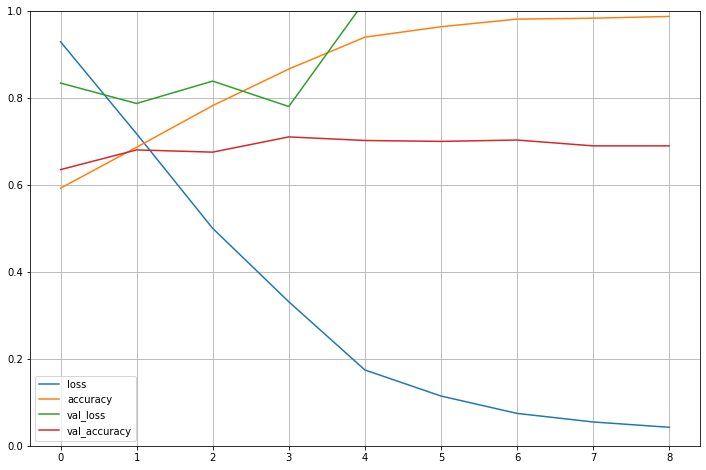

In [56]:
model_eval(history) #seperate val and loss

### Import Headlines To Test Model

In [59]:
import http.client

conn = http.client.HTTPSConnection("bloomberg-market-and-financial-news.p.rapidapi.com")

headers = {
    'x-rapidapi-key': "e42e1d27damsh0c4821dfe25b64ap17fdd0jsn1cf1f347448c",
    'x-rapidapi-host': "bloomberg-market-and-financial-news.p.rapidapi.com"
    }

conn.request("GET", "/market/get-cross-currencies?id=aed%2Caud%2Cbrl%2Ccad%2Cchf%2Ccnh%2Ccny%2Ccop%2Cczk%2Cdkk%2Ceur%2Cgbp%2Chkd%2Chuf%2Cidr%2Cils%2Cinr%2Cjpy%2Ckrw%2Cmxn%2Cmyr%2Cnok%2Cnzd%2Cphp%2Cpln%2Crub%2Csek%2Csgd%2Cthb%2Ctry%2Ctwd%2Cusd%2Czar", headers=headers)

res = conn.getresponse()
data = res.read()

print(data.decode("utf-8"))

{"result":{"MXNJPY:cur":{"baseName":"JAPANESE YEN","securityType":"CROSS","symbol":"MXNJPY","country":"Japan","currency":"JPY","resourceType":"Currency","resourceSubtype":"Cross","region":"APAC","ticker":"mxnjpy:cur","tickerName":"MXNJPY:CUR","template":"Currency","tinyName":"MXN-JPY","name":"MXNJPY Spot Exchange Rate - Price of 1 MXN in JPY","watchlist":true,"resourceId":"MXNJPY:CUR","last":"5.1969","netChange":"-0.0357","lastPriceTime":1612896234,"yearHigh":"6.0126","dayHigh":"5.2344","yearLow":"4.2259","sourceCurrency":"MXN","dayLow":"5.1946","pctChange":"-0.68"},"JPYMXN:cur":{"baseName":"MEXICAN PESO","securityType":"CROSS","symbol":"JPYMXN","country":"Mexico","currency":"MXN","resourceType":"Currency","resourceSubtype":"Cross","region":"AMERICAS","ticker":"jpymxn:cur","tickerName":"JPYMXN:CUR","template":"Currency","tinyName":"JPY-MXN","name":"JPYMXN Spot Exchange Rate - Price of 1 JPY in MXN","watchlist":true,"resourceId":"JPYMXN:CUR","last":"0.192","netChange":"0.001","lastPrice

In [84]:
data = json.loads(data.decode('utf-8'))
data

{'result': {'MXNJPY:cur': {'baseName': 'JAPANESE YEN',
   'securityType': 'CROSS',
   'symbol': 'MXNJPY',
   'country': 'Japan',
   'currency': 'JPY',
   'resourceType': 'Currency',
   'resourceSubtype': 'Cross',
   'region': 'APAC',
   'ticker': 'mxnjpy:cur',
   'tickerName': 'MXNJPY:CUR',
   'template': 'Currency',
   'tinyName': 'MXN-JPY',
   'name': 'MXNJPY Spot Exchange Rate - Price of 1 MXN in JPY',
   'watchlist': True,
   'resourceId': 'MXNJPY:CUR',
   'last': '5.1969',
   'netChange': '-0.0357',
   'lastPriceTime': 1612896234,
   'yearHigh': '6.0126',
   'dayHigh': '5.2344',
   'yearLow': '4.2259',
   'sourceCurrency': 'MXN',
   'dayLow': '5.1946',
   'pctChange': '-0.68'},
  'JPYMXN:cur': {'baseName': 'MEXICAN PESO',
   'securityType': 'CROSS',
   'symbol': 'JPYMXN',
   'country': 'Mexico',
   'currency': 'MXN',
   'resourceType': 'Currency',
   'resourceSubtype': 'Cross',
   'region': 'AMERICAS',
   'ticker': 'jpymxn:cur',
   'tickerName': 'JPYMXN:CUR',
   'template': 'Curre

In [105]:
import http.client

conn = http.client.HTTPSConnection("yahoo-finance-low-latency.p.rapidapi.com")

headers = {
    'x-rapidapi-key': "e42e1d27damsh0c4821dfe25b64ap17fdd0jsn1cf1f347448c",
    'x-rapidapi-host': "yahoo-finance-low-latency.p.rapidapi.com"
    }

conn.request("GET", "/v2/finance/news?symbols=AAPL%2CMSFT", headers=headers)

res = conn.getresponse()
data = res.read()

print(data.decode("utf-8"))

{"Featured":{"result":[],"error":null},"Meta":{"result":[{"next":1611855341}],"error":null},"Content":{"result":[{"rank":3,"id":"65b53896-faf4-3a06-9d0d-a63cf3c83192","tag":"news","title":"Best Dow Jones Stocks To Buy And Watch In February 2021: Apple, Nike Near New Buy Points","summary":"The Dow Jones Industrial Average slid from record highs at the end of January, as the current stock market pullback continues. The best Dow Jones stocks to buy and watch in February 2021 are Apple, Microsoft and Nike.","url":"https://www.investors.com/research/dow-jones-stocks/?src=A00220&yptr=yahoo","author_name":"SCOTT LEHTONEN","provider_publish_time":1612979373,"provider_name":"Investor's Business Daily","hosted":false,"tickers":["AAPL"],"thumbnail":"https://media.zenfs.com/en/ibd.com/5d92f476f281306ed580de788026901b","featured":false,"timeZoneShortName":"EST","timeZoneFullName":"America/New_York","gmtOffSetMilliseconds":-18000000,"imageSet":{}},{"rank":9,"id":"06c5a947-3c6a-3900-a50f-cd5b7fe2e429

In [107]:
# loading a string
data = json.loads(data.decode('utf-8'))
data

{'Featured': {'result': [], 'error': None},
 'Meta': {'result': [{'next': 1611855341}], 'error': None},
 'Content': {'result': [{'rank': 3,
    'id': '65b53896-faf4-3a06-9d0d-a63cf3c83192',
    'tag': 'news',
    'title': 'Best Dow Jones Stocks To Buy And Watch In February 2021: Apple, Nike Near New Buy Points',
    'summary': 'The Dow Jones Industrial Average slid from record highs at the end of January, as the current stock market pullback continues. The best Dow Jones stocks to buy and watch in February 2021 are Apple, Microsoft and Nike.',
    'url': 'https://www.investors.com/research/dow-jones-stocks/?src=A00220&yptr=yahoo',
    'author_name': 'SCOTT LEHTONEN',
    'provider_publish_time': 1612979373,
    'provider_name': "Investor's Business Daily",
    'hosted': False,
    'tickers': ['AAPL'],
    'thumbnail': 'https://media.zenfs.com/en/ibd.com/5d92f476f281306ed580de788026901b',
    'featured': False,
    'timeZoneShortName': 'EST',
    'timeZoneFullName': 'America/New_York',


In [117]:
print(data['Content'][1]['title'])



KeyError: 1